<a href="https://colab.research.google.com/github/Love1117/Machine_learning-Projects/blob/main/Machine_Learning%20Project/04_NLP%20Projects/Transfer%20Learning%20(Bert%2C%20T5%2C%20LLaMa%2C%20etc..%20(transformers)/Text%20Generation/Text_Summarization_using_T5_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

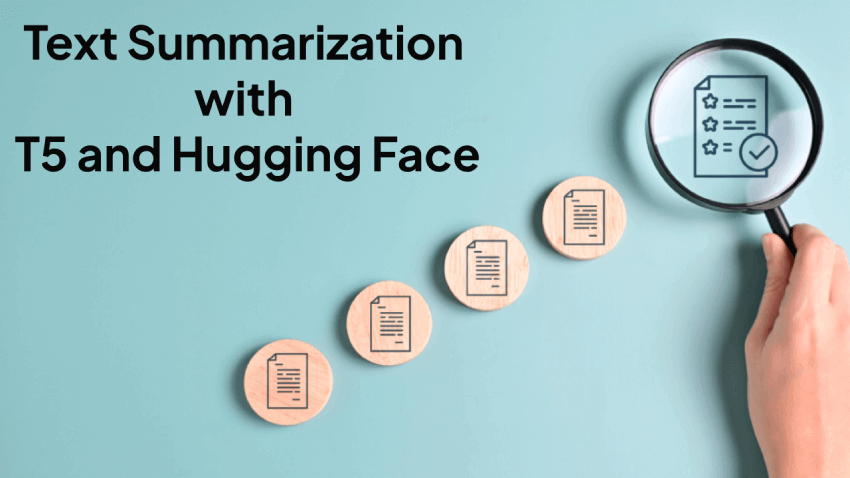
#**Project Summary: Text Summarization Using T5-Small**

##**Overview**

This project implements an abstractive text summarization model using the T5-Small transformer on the California Billsum dataset (Hugging Face). After fine-tuning the model on legislative bill summaries, it achieved the following performance metrics:

ROUGE-1: 0.15

ROUGE-2: 0.05

ROUGE-L: 0.12


The model successfully generated concise summaries that capture the core intent of each bill.


---

##**Aim of the Project**

To apply transfer learning with the T5 architecture for high-level abstractive summarization.

To evaluate summarization quality using standard ROUGE metrics.

To build a lightweight summarization pipeline that can generalize to long, formal documents.



In [ ]:
from datasets import load_dataset

book_data = load_dataset("ubaada/booksum-complete-cleaned", "chapters")
print(book_data["train"][0]['summary'][0]['text'])

chapters/train.jsonl:   0%|          | 0.00/193M [00:00<?, ?B/s]

In [ ]:
book_data

##**Load BillSum dataset:** I loaded other dataset which will be used for later projects, but for this project am using the BillSum dataset from the hugging face  Datasets library.

In [ ]:
billsum = load_dataset("billsum", split="ca_test")
billsum

##**Split the dataset into a train and test set with the train_test_split method**

In [ ]:
split_billsum = billsum.train_test_split(test_size=0.2)
split_billsum

##**Viewing some text example**

In [ ]:
split_billsum["train"]["text"][1]

##**Preprocess:**
The next step is to load a T5 tokenizer to process text and summary:

In [ ]:
from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

##**Creating a preprocessing function which will Tokenize my text**

In [ ]:
prefix = "summarize: "


def preprocess_function(examples):
  inputs = [prefix + doc for doc in examples["text"]]
  model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

  labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

##**Apply the preprocessing function over the entire dataset**

In [ ]:
tokenized_billsum= split_billsum.map(preprocess_function, batched=True)
tokenized_billsum

##**As you can see it now has an input_IDs and attention_mask**

In [ ]:
tokenized_billsum

##**Confirming text has been Tokenized**

In [ ]:
tokens = tokenized_billsum["train"]["input_ids"][0]
tokens[:10]

##**Create a batch of examples using DataCollatorForSeq2Seq.** It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

##**Loading Evaluate metrics**

In [ ]:
!pip install evaluate
!pip install rouge_score

import evaluate

rouge = evaluate.load("rouge")

##**Create a function that passes my predictions and labels to compute and calculate the ROUGE metric**

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  result["gen_len"] = np.mean(prediction_lens)

  return {k: round(v, 4) for k, v in result.items()}

##**Load T5 with AutoModelForSeq2SeqLM**
also importing my training arguments and  Seq2SeqTrainer class where I can define my training parameters

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

##**Defining my training hyperparameters in Seq2SeqTrainingArguments. **


Passing the training arguments to Seq2SeqTrainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.

In [ ]:
training_args = Seq2SeqTrainingArguments(
      output_dir="my_awesome_billsum_model",
      eval_strategy="epoch",
      learning_rate=2e-5,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      weight_decay=0.01,
      save_total_limit=3,
      num_train_epochs=4,
      predict_with_generate=True,
      fp16=True,
      push_to_hub=False) # Changed to False to prevent the 403 Forbidden error


trainer = Seq2SeqTrainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_billsum["train"],
      eval_dataset=tokenized_billsum["test"],
      processing_class=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics,)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate(tokenized_billsum["test"])

##**Metric**
#**ROUGE-1	0.15**
#**ROUGE-2	0.05**
#**ROUGE-L	0.12**
#*It is a good score and acceptable 👍*

##**Great, now that you’ve finetuned a model, you can use it for inference!**

#**Next Step:**
##**It's time i test our model. i will Come up with some text I would like to summarize**

In [ ]:
text = "summarize: The Inflation Reduction Act lowers prescription drug costs, health care costs, and energy costs. It's the most aggressive action on tackling the climate crisis in American history, which will lift up American workers and create good-paying, union jobs across the country. It'll lower the deficit and ask the ultra-wealthy and corporations to pay their fair share. And no one making under $400,000 per year will pay a penny more in taxes."
text

##**Let's try out our finetuned model for inference in a pipeline**

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", max_length=51, model=model, tokenizer=tokenizer)
summarizer(text, max_length=51)

##**Summarized Output**

##**2nd Example**

In [ ]:
text2 = split_billsum["test"]["text"][3]
text2

In [ ]:
summarizer = pipeline("summarization", max_length=51, model=model, tokenizer=tokenizer)
summarizer(text2, max_length=51)

##**Summarized Output**

##**Conclusion / Deployment Summary**

When deployed, this T5-Small summarization model can:

Automatically generate short, meaningful summaries of long texts such as reports, bills, articles, and documents.

Improve information retrieval, document understanding, and workflow efficiency for users handling large text volumes.

Serve as a fast, resource-efficient module for content processing systems or NLP applications.
